In [1]:
# ---------------------------------------- File 6_MIWM_roads_2018 ---------------------------------------- #
# This is file is the sixth step in creating the NSMI which gathers, analyses, and merges spatial data 
# This script will locate the shapefiles containing information of roads in the Netherlands from the Dutch Ministry of Infrastructure and Water Management as it was at the end of 2018.

# Importing necessary libraries for this script
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import multiprocessing as mp
from shapely.geometry import box
import contextily as ctx
import concurrent.futures
import os

In [2]:
# ---------------------------------------- Part 1 ---------------------------------------- #
# This part locates the shapefile containing the road geometries and the maximum speed information for 2018 from the Dutch Ministry of Infrastructure and Water Management.
# After locating and analysing the files, the files can be merged and the redundant columns can be removed. 
# This part allows furher analysis on the road lengths per neighborhood that will be done in step 2. 

In [3]:
# This line sets the path to the shapefile
shapefile_source_2018 = r'C:\Users\20182306\OneDrive - TU Eindhoven\Documents\Master - Jaar 1, 2 & 3\year 3\INPUT\roads\01-11-2018\01-11-2018\Speed\Wegvakdeel N\Wegvakken.shp'

# This line uses geopandas to read the shapefile and load it into a GeoDataFrame
roads_2018_original = gpd.read_file(shapefile_source_2018)

In [4]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)

display(roads_2018_original.head(5))

,WEGVAK_ID,WVK_BEGDAT,NWB_VERSIE,PVE_CODE,GME_ID,GME_NAAM,STT_NAAM,WEGNUMMER,BHRSOORT,BHRCODE,BHRNAAM,FK_VELD1,geometry
0,47194001,1997-08-29,2018-11-01,ZL,717,Veere,Schamsweg,None,G,717,Veere,004719400119970829,"LINESTRING (23958.000 397503.000, 23994.000 39..."
1,47194002,1997-08-29,2018-11-01,ZL,717,Veere,Schamsweg,None,G,717,Veere,004719400219970829,"LINESTRING (23919.000 397500.000, 23958.000 39..."
2,46184029,1998-02-14,2018-11-01,ZL,717,Veere,Swaalingestraat,None,G,717,Veere,004618402919980214,"LINESTRING (23199.000 392248.000, 23213.000 39..."
3,46184030,1998-02-14,2018-11-01,ZL,717,Veere,Swaalingestraat,None,G,717,Veere,004618403019980214,"LINESTRING (23207.000 392265.000, 23213.000 39..."
4,46184031,1998-02-14,2018-11-01,ZL,717,Veere,Swaalingestraat,None,G,717,Veere,004618403119980214,"LINESTRING (23213.000 392258.000, 23240.000 39..."


In [5]:
# Get the number of rows and columns
num_rows, num_cols = roads_2018_original.shape
print(f"The dataset has {num_rows} rows and {num_cols} columns.")

# Get descriptive statistics
stats = roads_2018_original.describe()
print(stats)

The dataset has 1041599 rows and 13 columns.
          WEGVAK_ID        GME_ID
count  1.041599e+06  1.041599e+06
mean   3.074262e+08  7.468615e+02
std    1.095101e+08  5.958427e+02
min    2.714200e+07  3.000000e+00
25%    2.192030e+08  2.970000e+02
50%    3.072100e+08  5.760000e+02
75%    3.900640e+08  9.350000e+02
max    5.555570e+08  1.955000e+03


In [6]:
# This line sets the path to the excel file containing the maximum speed information
max_speed_source_2018 = r'C:\Users\20182306\OneDrive - TU Eindhoven\Documents\Master - Jaar 1, 2 & 3\year 3\INPUT\roads\01-11-2018\01-11-2018\Speed\Wegvakdeel N\MAX_SNELHEDEN.CSV'

# This line uses geopandas to read the shapefile and load it into a GeoDataFrame
max_speed_2018_original = pd.read_csv(max_speed_source_2018, sep='\s+')

In [7]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)

display(max_speed_2018_original.head(5))

,WEGVAK_ID,WVK_BEGDAT,NWB_VERSIE,HDE_SHT,D_HDE_SHT,FK_VELD1
0,47194001,29-08-1997,01-11-2018,KMH_60,13-10-2016,4719400119970829
1,47194002,29-08-1997,01-11-2018,KMH_60,13-10-2016,4719400219970829
2,46184029,14-02-1998,01-11-2018,KMH_30,13-10-2016,4618402919980214
3,46184030,14-02-1998,01-11-2018,KMH_30,13-10-2016,4618403019980214
4,46184031,14-02-1998,01-11-2018,KMH_30,13-10-2016,4618403119980214


In [8]:
# Get the number of rows and columns
num_rows, num_cols = max_speed_2018_original.shape
print(f"The dataset has {num_rows} rows and {num_cols} columns.")

# Get descriptive statistics
stats = max_speed_2018_original.describe()
print(stats)

# Get descriptive statistics of the max speed column
stats = max_speed_2018_original['HDE_SHT'].describe()
print(stats)

# Get the number of NaN values in the HDE_SHT column
num_nan = max_speed_2018_original['HDE_SHT'].isna().sum()
print(f"The HDE_SHT column has {num_nan} NaN values.")

The dataset has 1041599 rows and 6 columns.
          WEGVAK_ID      FK_VELD1
count  1.041599e+06  1.041599e+06
mean   3.074262e+08  3.074262e+16
std    1.095101e+08  1.095101e+16
min    2.714200e+07  2.714200e+15
25%    2.192030e+08  2.192030e+16
50%    3.072100e+08  3.072100e+16
75%    3.900640e+08  3.900640e+16
max    5.555570e+08  5.555570e+16
count     1041599
unique         13
top        KMH_30
freq       600329
Name: HDE_SHT, dtype: object
The HDE_SHT column has 0 NaN values.


In [9]:
# Merge the GeoDataFrame containing the road geodata with the DataFrame containing the speed information
roads_with_speed_2018 = roads_2018_original.merge(max_speed_2018_original, on= 'WEGVAK_ID', how='left')

# Get the number of NaN values in the HDE_SHT column
num_nan = roads_with_speed_2018['HDE_SHT'].isna().sum()
print(f"The HDE_SHT column has {num_nan} NaN values.")
num_rows, num_cols = roads_with_speed_2018.shape
print(f"The dataset has {num_rows} rows and {num_cols} columns.")

The HDE_SHT column has 0 NaN values.
The dataset has 1041599 rows and 18 columns.


In [10]:
# Make a copy of the dataframe with only the specified columns
roads_with_speed_2018_cleaned = roads_with_speed_2018[['WEGVAK_ID', 'geometry', 'HDE_SHT']].copy()

# Rename the columns
roads_with_speed_2018_cleaned = roads_with_speed_2018_cleaned.rename(columns={'WEGVAK_ID': 'ROAD_ID', 'HDE_SHT': 'MAX_SPEED'})

display(roads_with_speed_2018_cleaned.head(10))

# Get the number of NaN values in the dataset
num_nan_MAXSPEED = roads_with_speed_2018_cleaned['MAX_SPEED'].isna().sum()
print(f"The MAX_SPEED column has {num_nan_MAXSPEED} NaN values.")

num_nan_geometry = roads_with_speed_2018_cleaned['geometry'].isna().sum()
print(f"The geometry column has {num_nan_geometry} NaN values.")

num_nan_ROADID = roads_with_speed_2018_cleaned['ROAD_ID'].isna().sum()
print(f"The HDE_SHT column has {num_nan_ROADID} NaN values.")

num_rows, num_cols = roads_with_speed_2018_cleaned.shape
print(f"The dataset has {num_rows} rows and {num_cols} columns.")

# Show how many unique values the column MAX_SPEED has.
num_unique_values = roads_with_speed_2018_cleaned['MAX_SPEED'].nunique()
print(f"The MAX_SPEED column has {num_unique_values} unique values.")

# Get the unique values in the MAX_SPEED column
unique_values = roads_with_speed_2018_cleaned['MAX_SPEED'].unique()
print(f"The unique values in the MAX_SPEED column are: {unique_values}")

,ROAD_ID,geometry,MAX_SPEED
0,47194001,"LINESTRING (23958.000 397503.000, 23994.000 39...",KMH_60
1,47194002,"LINESTRING (23919.000 397500.000, 23958.000 39...",KMH_60
2,46184029,"LINESTRING (23199.000 392248.000, 23213.000 39...",KMH_30
3,46184030,"LINESTRING (23207.000 392265.000, 23213.000 39...",KMH_30
4,46184031,"LINESTRING (23213.000 392258.000, 23240.000 39...",KMH_30
5,96204002,"LINESTRING (48347.000 402400.000, 48361.000 40...",KMH_30
6,96204003,"LINESTRING (48241.000 402269.000, 48255.000 40...",KMH_30
7,96204004,"LINESTRING (48255.000 402163.000, 48263.000 40...",KMH_30
8,96204005,"LINESTRING (48377.000 402112.000, 48492.000 40...",KMH_30
9,96204006,"LINESTRING (48485.000 402188.000, 48492.000 40...",KMH_30


The MAX_SPEED column has 0 NaN values.
The geometry column has 0 NaN values.
The HDE_SHT column has 0 NaN values.
The dataset has 1041599 rows and 3 columns.
The MAX_SPEED column has 13 unique values.
The unique values in the MAX_SPEED column are: ['KMH_60' 'KMH_30' 'KMH_80' 'KMH_50' 'KMH_70' 'HST_NOA' 'KMH_12' 'KMH_100'
 'KMH_120' 'KMH_90' 'KMH_130' 'HST_NVT' 'HST_ADS']


In [11]:
# Save the GeoDataFrame as a .gpkg file
roads_with_speed_2018_cleaned.to_file("C:/Users/20182306/OneDrive - TU Eindhoven/Documents/We-Boost/Repositories/Mobility-Index/intermediate/roads_with_max_speed_2018.gpkg", driver="GPKG")

In [12]:
# ---------------------------------------- Part 2 ---------------------------------------- #
# This part locates the geopackage file 5_2_1 which contains the socio-demographic data, proximity data, greenery data, water, and build-up area data for every neighborhood in 2018.
# After locating this file, the geopackage with the geodata of roads with the corresponding maximum speed will be used to obtain the road lengths per maxmimum speeds classification per neighborhood. 

In [13]:
# This line sets the path to the shapefile
geopackage_input_2018_location = r'C:\Users\20182306\OneDrive - TU Eindhoven\Documents\We-Boost\Repositories\Mobility-Index\output\5_2_5_OSM_buildings_2018.gpkg'

# This line uses geopandas to read the geopackage with the neighborhood data and loads it into a GeoDataFrame
geopackage_input_2018 = gpd.read_file(geopackage_input_2018_location)

# Display the first 5 rows of the GeoDataFrame which is the input of the neighborhood data.
display(geopackage_input_2018.head(5))

,neighborhoodcode,neighborhoodname,populationdensityperkm2,percentage0to15years,percentage15to25years,percentage25to45years,percentage45to65years,percentage65yearsorolder,percentageonepersonhouseholds,percentagehouseholdswithoutchildren,percentagehouseholdswithchildren,percentagewesternmigrationbackground,percentagenonwesternmigrationbackground,percentagemen,Distancetolargesupermarket,Distancetodailylifeprovisions,DistanceToPrimaryEducation,DistanceToSecundaryEducation,area_greenery,area_water,area_buildings,geometry
0,BU00030000,Appingedam-Centrum,2798.0,10.0,10.0,21.0,30.0,29.0,53.0,28.0,18.0,6.0,4.0,47.6,0.6,0.3,1.2,1.1,2.038273e+05,45112.499227,147263.071692,"MULTIPOLYGON (((252643.203 594343.688, 252604...."
1,BU00030001,Appingedam-West,1919.0,16.0,11.0,19.0,34.0,20.0,27.0,38.0,36.0,5.0,4.0,49.7,1.3,0.9,1.0,2.1,6.854374e+05,42916.667426,148432.690856,"MULTIPOLYGON (((251260.496 594393.830, 251260...."
2,BU00030002,Appingedam-Oost,2045.0,16.0,10.0,21.0,28.0,25.0,36.0,31.0,33.0,9.0,10.0,48.4,0.6,0.6,0.7,0.8,9.980040e+05,100259.634202,283064.381879,"MULTIPOLYGON (((253641.500 594417.813, 253617...."
3,BU00030007,Verspreide huizen Damsterdiep en Eemskanaal,61.0,22.0,11.0,22.0,34.0,10.0,18.0,29.0,53.0,7.0,2.0,53.0,1.8,1.7,1.3,2.8,4.729924e+06,115014.240411,97185.701625,"MULTIPOLYGON (((249539.950 593217.579, 249533...."
4,BU00030008,Verspreide huizen ten zuiden van Eemskanaal,18.0,15.0,10.0,11.0,48.0,17.0,20.0,44.0,37.0,3.0,1.0,55.0,2.7,2.7,2.8,3.5,4.472402e+06,100290.881349,57381.389051,"MULTIPOLYGON (((254983.248 592485.983, 254956...."


In [14]:
# Set the CRS for both GeoDataFrames
geopackage_input_2018 = geopackage_input_2018.to_crs('EPSG:28992')
roads_with_speed_2018_cleaned = roads_with_speed_2018_cleaned.to_crs('EPSG:28992')

In [15]:
# Create a bounding box for each neighborhood geometry
geopackage_input_2018['bounding_box'] = geopackage_input_2018['geometry'].apply(lambda x: x.bounds)
display(geopackage_input_2018.head(5))

,neighborhoodcode,neighborhoodname,populationdensityperkm2,percentage0to15years,percentage15to25years,percentage25to45years,percentage45to65years,percentage65yearsorolder,percentageonepersonhouseholds,percentagehouseholdswithoutchildren,percentagehouseholdswithchildren,percentagewesternmigrationbackground,percentagenonwesternmigrationbackground,percentagemen,Distancetolargesupermarket,Distancetodailylifeprovisions,DistanceToPrimaryEducation,DistanceToSecundaryEducation,area_greenery,area_water,area_buildings,geometry,bounding_box
0,BU00030000,Appingedam-Centrum,2798.0,10.0,10.0,21.0,30.0,29.0,53.0,28.0,18.0,6.0,4.0,47.6,0.6,0.3,1.2,1.1,2.038273e+05,45112.499227,147263.071692,"MULTIPOLYGON (((252643.203 594343.688, 252604....","(252293.594, 593473.3126, 253687.1862, 594548...."
1,BU00030001,Appingedam-West,1919.0,16.0,11.0,19.0,34.0,20.0,27.0,38.0,36.0,5.0,4.0,49.7,1.3,0.9,1.0,2.1,6.854374e+05,42916.667426,148432.690856,"MULTIPOLYGON (((251260.496 594393.830, 251260....","(251260.496, 593038.5148, 252888.297, 594486.7..."
2,BU00030002,Appingedam-Oost,2045.0,16.0,10.0,21.0,28.0,25.0,36.0,31.0,33.0,9.0,10.0,48.4,0.6,0.6,0.7,0.8,9.980040e+05,100259.634202,283064.381879,"MULTIPOLYGON (((253641.500 594417.813, 253617....","(252503.0, 592402.0002, 254809.06, 594573.5058)"
3,BU00030007,Verspreide huizen Damsterdiep en Eemskanaal,61.0,22.0,11.0,22.0,34.0,10.0,18.0,29.0,53.0,7.0,2.0,53.0,1.8,1.7,1.3,2.8,4.729924e+06,115014.240411,97185.701625,"MULTIPOLYGON (((249539.950 593217.579, 249533....","(249376.48, 591064.5096, 253847.9062, 593535.3..."
4,BU00030008,Verspreide huizen ten zuiden van Eemskanaal,18.0,15.0,10.0,11.0,48.0,17.0,20.0,44.0,37.0,3.0,1.0,55.0,2.7,2.7,2.8,3.5,4.472402e+06,100290.881349,57381.389051,"MULTIPOLYGON (((254983.248 592485.983, 254956....","(250151.0912, 590276.85, 255043.375, 592703.1484)"


In [16]:
# Create a dictionary to store the roads DataFrames for each neighborhood
neighborhood_roads = {}

# Iterate over each row in geopackage_input_2018
for idx, neighborhood in geopackage_input_2018.iterrows():
    # Create a box from the bounding box
    bounding_box = box(*neighborhood['bounding_box'])
    
    # Check which roads are completely within the bounding box
    roads_within = roads_with_speed_2018_cleaned[roads_with_speed_2018_cleaned['geometry'].within(bounding_box)]
    
    # Check which roads are partly within the bounding box
    roads_intersect = roads_with_speed_2018_cleaned[roads_with_speed_2018_cleaned['geometry'].intersects(bounding_box)]
    
    # Concatenate the roads that are within or intersect the bounding box
    roads = pd.concat([roads_within, roads_intersect]).drop_duplicates()

    # Convert the neighborhood geometry to a GeoDataFrame and set its CRS
    neighborhood_gdf = gpd.GeoDataFrame(geometry=[neighborhood['geometry']], crs=roads.crs)
    
    # Clip the roads to the neighborhood geometry
    clipped_roads = gpd.overlay(roads, neighborhood_gdf, how='intersection')
    
    # Store the clipped roads DataFrame in the dictionary
    neighborhood_roads[idx] = clipped_roads

C:\Users\20182306\AppData\Local\Temp\ipykernel_17088\726033694.py:22: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  clipped_roads = gpd.overlay(roads, neighborhood_gdf, how='intersection')
C:\Users\20182306\AppData\Local\Temp\ipykernel_17088\726033694.py:22: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  clipped_roads = gpd.overlay(roads, neighborhood_gdf, how='intersection')
C:\Users\20182306\AppData\Local\Temp\ipykernel_17088\726033694.py:22: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  clipped_roads = gpd.overlay(roads, neighborhood_gdf, how='intersection')
C:\Users\20182306\AppData\Local\Temp\ipykernel

In [17]:
# Define the speed categories
speed_categories = ['KMH_60', 'KMH_30', 'KMH_80', 'KMH_50', 'KMH_70', 'HST_NOA', 'KMH_12', 'KMH_100', 'KMH_120', 'KMH_90', 'KMH_130', 'HST_NVT']

# Initialize the speed categories columns in geopackage_input_2018 with 0.0 (float)
for category in speed_categories:
    geopackage_input_2018[category] = 0.0

# Iterate over the neighborhood_roads dictionary
for idx, roads in neighborhood_roads.items():
    # Calculate the length of each road
    roads['length'] = roads['geometry'].length
    
    # Group the roads by the MAX_SPEED column and calculate the sum of their lengths
    road_lengths = roads.groupby('MAX_SPEED')['length'].sum()
    
    # Assign the road lengths to the corresponding columns in geopackage_input_2018
    for category in speed_categories:
        if category in road_lengths:
            # Convert the column to float before setting the value
            geopackage_input_2018[category] = geopackage_input_2018[category].astype(float)
            geopackage_input_2018.loc[idx, category] = road_lengths[category]

In [18]:
display(geopackage_input_2018.head(10))

,neighborhoodcode,neighborhoodname,populationdensityperkm2,percentage0to15years,percentage15to25years,percentage25to45years,percentage45to65years,percentage65yearsorolder,percentageonepersonhouseholds,percentagehouseholdswithoutchildren,percentagehouseholdswithchildren,percentagewesternmigrationbackground,percentagenonwesternmigrationbackground,percentagemen,Distancetolargesupermarket,Distancetodailylifeprovisions,DistanceToPrimaryEducation,DistanceToSecundaryEducation,area_greenery,area_water,area_buildings,geometry,bounding_box,KMH_60,KMH_30,KMH_80,KMH_50,KMH_70,HST_NOA,KMH_12,KMH_100,KMH_120,KMH_90,KMH_130,HST_NVT
0,BU00030000,Appingedam-Centrum,2798.0,10.0,10.0,21.0,30.0,29.0,53.0,28.0,18.0,6.0,4.0,47.6,0.6,0.3,1.2,1.1,2.038273e+05,45112.499227,147263.071692,"MULTIPOLYGON (((252643.203 594343.688, 252604....","(252293.594, 593473.3126, 253687.1862, 594548....",788.763891,10588.552643,0.000000,1761.305147,0.000000,2542.547027,0.0,0.000000,0.000000,0.0,0.0,0.0
1,BU00030001,Appingedam-West,1919.0,16.0,11.0,19.0,34.0,20.0,27.0,38.0,36.0,5.0,4.0,49.7,1.3,0.9,1.0,2.1,6.854374e+05,42916.667426,148432.690856,"MULTIPOLYGON (((251260.496 594393.830, 251260....","(251260.496, 593038.5148, 252888.297, 594486.7...",1568.972879,12963.207626,1285.926516,3915.788220,0.000000,1094.361706,0.0,0.000000,0.000000,0.0,0.0,0.0
2,BU00030002,Appingedam-Oost,2045.0,16.0,10.0,21.0,28.0,25.0,36.0,31.0,33.0,9.0,10.0,48.4,0.6,0.6,0.7,0.8,9.980040e+05,100259.634202,283064.381879,"MULTIPOLYGON (((253641.500 594417.813, 253617....","(252503.0, 592402.0002, 254809.06, 594573.5058)",916.150303,15570.360570,2242.369186,9796.344545,0.000000,1539.279296,0.0,2963.944644,10.985198,0.0,0.0,0.0
3,BU00030007,Verspreide huizen Damsterdiep en Eemskanaal,61.0,22.0,11.0,22.0,34.0,10.0,18.0,29.0,53.0,7.0,2.0,53.0,1.8,1.7,1.3,2.8,4.729924e+06,115014.240411,97185.701625,"MULTIPOLYGON (((249539.950 593217.579, 249533....","(249376.48, 591064.5096, 253847.9062, 593535.3...",7354.265928,1747.680380,0.000000,2481.395047,0.000000,4541.112733,0.0,0.000000,0.000000,0.0,0.0,0.0
4,BU00030008,Verspreide huizen ten zuiden van Eemskanaal,18.0,15.0,10.0,11.0,48.0,17.0,20.0,44.0,37.0,3.0,1.0,55.0,2.7,2.7,2.8,3.5,4.472402e+06,100290.881349,57381.389051,"MULTIPOLYGON (((254983.248 592485.983, 254956....","(250151.0912, 590276.85, 255043.375, 592703.1484)",14583.351683,0.000000,2790.126721,895.828162,188.993315,413.861564,0.0,1054.321788,0.000000,0.0,0.0,0.0
5,BU00030009,Verspreide huizen ten noorden van het Damsterdiep,21.0,20.0,13.0,14.0,34.0,19.0,25.0,38.0,37.0,8.0,2.0,50.0,2.8,2.8,2.7,3.5,7.048819e+06,125567.594285,53296.188460,"MULTIPOLYGON (((251006.080 594433.230, 251000....","(249430.39, 593181.8126, 254795.464, 596685.285)",12213.446102,0.000000,1925.416108,2368.943981,0.000000,2288.068027,0.0,1842.330761,0.000000,0.0,0.0,0.0
6,BU00050000,Bedum,2511.0,16.0,12.0,21.0,30.0,22.0,30.0,34.0,36.0,4.0,4.0,49.6,0.6,0.6,0.6,8.2,8.407830e+05,135733.022809,460948.997203,"MULTIPOLYGON (((235731.703 592636.125, 235388....","(234671.0782, 590336.8752, 236994.0156, 592636...",861.304029,35398.908087,59.626717,4660.803988,0.000000,91.005494,0.0,0.000000,0.000000,0.0,0.0,0.0
7,BU00050001,Verspreide huizen Bedum,40.0,23.0,10.0,28.0,25.0,14.0,18.0,35.0,47.0,5.0,2.0,50.0,1.6,1.6,1.3,8.6,1.997795e+07,253619.345024,193128.174433,"MULTIPOLYGON (((233359.664 593250.002, 233339....","(233048.852, 587800.3126, 239442.591, 595019.5...",13749.967207,5001.132092,2895.902246,10400.153492,0.000000,1047.201736,0.0,681.530038,0.000000,0.0,0.0,0.0
8,BU00050002,Zuidwolde,1256.0,14.0,10.0,18.0,36.0,21.0,34.0,36.0,30.0,5.0,4.0,50.8,2.1,0.4,0.4,3.4,3.355341e+05,33214.675437,57060.711711,"MULTIPOLYGON (((235161.240 586891.248, 235163....","(235026.452, 586121.0822, 235981.297, 587369.3...",2737.159991,5109.959044,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
9,BU00050003,Verspreide huizen Zuidwolde,18.0,19.0,10.0,15.0,35.0,22.0,21.0,40.0,40.0,5.0,3.0,52.0,3.4,2.2,2.0,4.3,6.090057e+06,133625.094

In [19]:
# Rename the columns and merge columns in groups based on their speed category
geopackage_input_2018 = geopackage_input_2018.assign(
    road_length_residential = geopackage_input_2018[['KMH_12', 'KMH_30', 'KMH_50']].sum(axis=1),
    road_length_rural = geopackage_input_2018[['KMH_60', 'KMH_70', 'KMH_80']].sum(axis=1),
    road_length_highway = geopackage_input_2018[['KMH_90', 'KMH_100', 'KMH_120', 'KMH_130']].sum(axis=1),
    road_length_active = geopackage_input_2018[['HST_NOA', 'HST_NVT']].sum(axis=1)
)

In [20]:
display(geopackage_input_2018.head(10))

,neighborhoodcode,neighborhoodname,populationdensityperkm2,percentage0to15years,percentage15to25years,percentage25to45years,percentage45to65years,percentage65yearsorolder,percentageonepersonhouseholds,percentagehouseholdswithoutchildren,percentagehouseholdswithchildren,percentagewesternmigrationbackground,percentagenonwesternmigrationbackground,percentagemen,Distancetolargesupermarket,Distancetodailylifeprovisions,DistanceToPrimaryEducation,DistanceToSecundaryEducation,area_greenery,area_water,area_buildings,geometry,bounding_box,KMH_60,KMH_30,KMH_80,KMH_50,KMH_70,HST_NOA,KMH_12,KMH_100,KMH_120,KMH_90,KMH_130,HST_NVT,road_length_residential,road_length_rural,road_length_highway,road_length_active
0,BU00030000,Appingedam-Centrum,2798.0,10.0,10.0,21.0,30.0,29.0,53.0,28.0,18.0,6.0,4.0,47.6,0.6,0.3,1.2,1.1,2.038273e+05,45112.499227,147263.071692,"MULTIPOLYGON (((252643.203 594343.688, 252604....","(252293.594, 593473.3126, 253687.1862, 594548....",788.763891,10588.552643,0.000000,1761.305147,0.000000,2542.547027,0.0,0.000000,0.000000,0.0,0.0,0.0,12349.857790,788.763891,0.000000,2542.547027
1,BU00030001,Appingedam-West,1919.0,16.0,11.0,19.0,34.0,20.0,27.0,38.0,36.0,5.0,4.0,49.7,1.3,0.9,1.0,2.1,6.854374e+05,42916.667426,148432.690856,"MULTIPOLYGON (((251260.496 594393.830, 251260....","(251260.496, 593038.5148, 252888.297, 594486.7...",1568.972879,12963.207626,1285.926516,3915.788220,0.000000,1094.361706,0.0,0.000000,0.000000,0.0,0.0,0.0,16878.995847,2854.899395,0.000000,1094.361706
2,BU00030002,Appingedam-Oost,2045.0,16.0,10.0,21.0,28.0,25.0,36.0,31.0,33.0,9.0,10.0,48.4,0.6,0.6,0.7,0.8,9.980040e+05,100259.634202,283064.381879,"MULTIPOLYGON (((253641.500 594417.813, 253617....","(252503.0, 592402.0002, 254809.06, 594573.5058)",916.150303,15570.360570,2242.369186,9796.344545,0.000000,1539.279296,0.0,2963.944644,10.985198,0.0,0.0,0.0,25366.705115,3158.519489,2974.929842,1539.279296
3,BU00030007,Verspreide huizen Damsterdiep en Eemskanaal,61.0,22.0,11.0,22.0,34.0,10.0,18.0,29.0,53.0,7.0,2.0,53.0,1.8,1.7,1.3,2.8,4.729924e+06,115014.240411,97185.701625,"MULTIPOLYGON (((249539.950 593217.579, 249533....","(249376.48, 591064.5096, 253847.9062, 593535.3...",7354.265928,1747.680380,0.000000,2481.395047,0.000000,4541.112733,0.0,0.000000,0.000000,0.0,0.0,0.0,4229.075427,7354.265928,0.000000,4541.112733
4,BU00030008,Verspreide huizen ten zuiden van Eemskanaal,18.0,15.0,10.0,11.0,48.0,17.0,20.0,44.0,37.0,3.0,1.0,55.0,2.7,2.7,2.8,3.5,4.472402e+06,100290.881349,57381.389051,"MULTIPOLYGON (((254983.248 592485.983, 254956....","(250151.0912, 590276.85, 255043.375, 592703.1484)",14583.351683,0.000000,2790.126721,895.828162,188.993315,413.861564,0.0,1054.321788,0.000000,0.0,0.0,0.0,895.828162,17562.471719,1054.321788,413.861564
5,BU00030009,Verspreide huizen ten noorden van het Damsterdiep,21.0,20.0,13.0,14.0,34.0,19.0,25.0,38.0,37.0,8.0,2.0,50.0,2.8,2.8,2.7,3.5,7.048819e+06,125567.594285,53296.188460,"MULTIPOLYGON (((251006.080 594433.230, 251000....","(249430.39, 593181.8126, 254795.464, 596685.285)",12213.446102,0.000000,1925.416108,2368.943981,0.000000,2288.068027,0.0,1842.330761,0.000000,0.0,0.0,0.0,2368.943981,14138.862210,1842.330761,2288.068027
6,BU00050000,Bedum,2511.0,16.0,12.0,21.0,30.0,22.0,30.0,34.0,36.0,4.0,4.0,49.6,0.6,0.6,0.6,8.2,8.407830e+05,135733.022809,460948.997203,"MULTIPOLYGON (((235731.703 592636.125, 235388....","(234671.0782, 590336.8752, 236994.0156, 592636...",861.304029,35398.908087,59.626717,4660.803988,0.000000,91.005494,0.0,0.000000,0.000000,0.0,0.0,0.0,40059.712074,920.930746,0.000000,91.005494
7,BU00050001,Verspreide huizen Bedum,40.0,23.0,10.0,28.0,25.0,14.0,18.0,35.0,47.0,5.0,2.0,50.0,1.6,1.6,1.3,8.6,1.997795e+07,253619.345024,193128.174433,"MULTIPOLYGON (((233359.664 593250.002, 233339....","(233048.852, 587800.3126, 239442.591, 595019.5...",13749.967207,5001.132092,2895.902246,10400.153492,0.000000,1047.201736,0.0,681.530038,0.000000,0.0,0.0,0.0,15401.285584,16645.869452,681.530038,1047.201736
8,BU00050002,Zuidwol

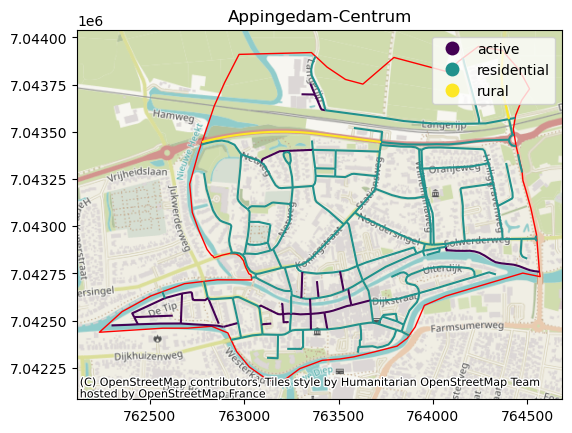

In [21]:
# Show the roads identification for an example neighborhood.

# Define the road groups
road_groups = {
    'KMH_12': 'residential',
    'KMH_30': 'residential',
    'KMH_50': 'residential',
    'KMH_60': 'rural',
    'KMH_70': 'rural',
    'KMH_80': 'rural',
    'KMH_90': 'highways',
    'KMH_100': 'highways',
    'KMH_120': 'highways',
    'KMH_130': 'highways',
    'HST_NOA': 'active',
    'HST_NVT': 'active'
}

# Select a neighborhood index
idx = 0  # replace with the index of the neighborhood you want to plot

# Get the buurtcode of the neighborhood
neighborhoodname = geopackage_input_2018.loc[idx, 'neighborhoodname']

# Convert the CRS to Web Mercator
geopackage_input_2018 = geopackage_input_2018.to_crs(epsg=3857)
neighborhood_roads[idx] = neighborhood_roads[idx].to_crs(epsg=3857)

# Create the 'group' column in neighborhood_roads[idx]
neighborhood_roads[idx]['group'] = neighborhood_roads[idx]['MAX_SPEED'].map(road_groups)

# Create the plot
ax = geopackage_input_2018.loc[[idx], 'geometry'].plot(color='none', edgecolor='red')
neighborhood_roads[idx].plot(ax=ax, column='group', cmap='viridis', legend=True)

# Add the basemap
ctx.add_basemap(ax)

# Set the title of the plot to the buurtcode of the neighborhood
plt.title(neighborhoodname)

plt.show()

In [23]:
# As a last task, save the geodataframe as geopackage. 
# Delete the unwanted columns
roads_finished = geopackage_input_2018.drop(columns=['bounding_box', 'KMH_60', 'KMH_30', 'KMH_80', 'KMH_50', 'KMH_70', 'HST_NOA', 'KMH_12', 'HST_NVT', 'KMH_120', 'KMH_100', 'KMH_130', 'KMH_90'])
display(roads_finished.head(5))

# Save the GeoDataFrame as a GeoPackage
roads_finished.to_file("C:/Users/20182306/OneDrive - TU Eindhoven/Documents/We-Boost/Repositories/Mobility-Index/output/6_MIWM_roads_2018.gpkg", driver="GPKG")

,neighborhoodcode,neighborhoodname,populationdensityperkm2,percentage0to15years,percentage15to25years,percentage25to45years,percentage45to65years,percentage65yearsorolder,percentageonepersonhouseholds,percentagehouseholdswithoutchildren,percentagehouseholdswithchildren,percentagewesternmigrationbackground,percentagenonwesternmigrationbackground,percentagemen,Distancetolargesupermarket,Distancetodailylifeprovisions,DistanceToPrimaryEducation,DistanceToSecundaryEducation,area_greenery,area_water,area_buildings,geometry,road_length_residential,road_length_rural,road_length_highway,road_length_active
0,BU00030000,Appingedam-Centrum,2798.0,10.0,10.0,21.0,30.0,29.0,53.0,28.0,18.0,6.0,4.0,47.6,0.6,0.3,1.2,1.1,2.038273e+05,45112.499227,147263.071692,"MULTIPOLYGON (((762841.639 7043637.555, 762772...",12349.857790,788.763891,0.000000,2542.547027
1,BU00030001,Appingedam-West,1919.0,16.0,11.0,19.0,34.0,20.0,27.0,38.0,36.0,5.0,4.0,49.7,1.3,0.9,1.0,2.1,6.854374e+05,42916.667426,148432.690856,"MULTIPOLYGON (((760533.836 7043768.320, 760534...",16878.995847,2854.899395,0.000000,1094.361706
2,BU00030002,Appingedam-Oost,2045.0,16.0,10.0,21.0,28.0,25.0,36.0,31.0,33.0,9.0,10.0,48.4,0.6,0.6,0.7,0.8,9.980040e+05,100259.634202,283064.381879,"MULTIPOLYGON (((764511.586 7043727.449, 764469...",25366.705115,3158.519489,2974.929842,1539.279296
3,BU00030007,Verspreide huizen Damsterdiep en Eemskanaal,61.0,22.0,11.0,22.0,34.0,10.0,18.0,29.0,53.0,7.0,2.0,53.0,1.8,1.7,1.3,2.8,4.729924e+06,115014.240411,97185.701625,"MULTIPOLYGON (((757621.270 7041856.440, 757609...",4229.075427,7354.265928,0.000000,4541.112733
4,BU00030008,Verspreide huizen ten zuiden van Eemskanaal,18.0,15.0,10.0,11.0,48.0,17.0,20.0,44.0,37.0,3.0,1.0,55.0,2.7,2.7,2.8,3.5,4.472402e+06,100290.881349,57381.389051,"MULTIPOLYGON (((766685.388 7040447.190, 766641...",895.828162,17562.471719,1054.321788,413.861564
